In [1]:
# Mounting your Google Drive is optional, and you could also simply copy and
# upload the data to your colab instance. This manula upload is also easy to do, 
# but you will have to figure out how to do it.
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import os
if not os.path.exists("/content/gdrive/My Drive/CS_543_MP4"):
    os.makedirs("/content/gdrive/My Drive/CS_543_MP4")
os.chdir("/content/gdrive/My Drive/CS_543_MP4")

In [4]:
import glob
import os
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, average_precision_score

from PIL import Image
import torch
from torch import nn
from torch.utils import data
from torchvision.transforms import ToTensor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
DATASET_PATH = 'data/sbd/'

class SegmentationDataset(data.Dataset):
    """
    Data loader for the Segmentation Dataset. If data loading is a bottleneck, 
    you may want to optimize this in for faster training. Possibilities include
    pre-loading all images and annotations into memory before training, so as 
    to limit delays due to disk reads.
    """
    def __init__(self, split="train", data_dir=DATASET_PATH):
        assert(split in ["train", "val", "test"])
        self.img_dir = os.path.join(data_dir, split)
        self.classes = []
        with open(os.path.join(data_dir, 'classes.txt'), 'r') as f:
          for l in f:
            self.classes.append(l.rstrip())
        self.n_classes = len(self.classes)
        self.split = split
        self.data = glob.glob(self.img_dir + '/*.jpg') 
        self.data = [os.path.splitext(l)[0] for l in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = Image.open(self.data[index] + '.jpg')
        gt = Image.open(self.data[index] + '.png')
        
        img = ToTensor()(img)
        gt = torch.LongTensor(np.asarray(gt)).unsqueeze(0)
        return img, gt

In [0]:
##########
#TODO: design your own network here. The expectation is to write from scratch. But it's okay to get some inspiration 
#from conference paper. The bottom line is that you will not just copy code from other repo
##########
class MyModel(nn.Module):

    def __init__(self): # feel free to modify input paramters
        super(MyModel, self).__init__()
        pass

    def forward(self, *params): # feel free to modify input paramters
        pass

In [0]:
def segmentation_eval(gts, preds, classes, plot_file_name):
    """
    @param    gts               numpy.ndarray   ground truth labels
    @param    preds             numpy.ndarray   predicted labels
    @param    classes           string          class names
    @param    plot_file_name    string          plot file names
    """
    ious, counts = compute_confusion_matrix(gts, preds)
    aps = compute_ap(gts, preds)
    plot_results(counts, ious, aps, classes, plot_file_name)
    for i in range(len(classes)):
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(classes[i], aps[i], ious[i]))
    print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(aps), np.mean(ious)))
    return aps, ious

def plot_results(counts, ious, aps, classes, file_name):
    fig, ax = plt.subplots(1,1)
    conf = counts / np.sum(counts, 1, keepdims=True)
    conf = np.concatenate([conf, np.array(aps).reshape(-1,1), 
                           np.array(ious).reshape(-1,1)], 1)
    conf = conf * 100.
    sns.heatmap(conf, annot=True, ax=ax, fmt='3.0f') 
    arts = [] 
    # labels, title and ticks
    _ = ax.set_xlabel('Predicted labels')
    arts.append(_)
    _ = ax.set_ylabel('True labels')
    arts.append(_)
    _ = ax.set_title('Confusion Matrix, mAP: {:5.1f}, mIoU: {:5.1f}'.format(
      np.mean(aps)*100., np.mean(ious)*100.))
    arts.append(_)
    _ = ax.xaxis.set_ticklabels(classes + ['AP', 'IoU'], rotation=90)
    arts.append(_)
    _ = ax.yaxis.set_ticklabels(classes, rotation=0)
    arts.append(_)
    fig.savefig(file_name, bbox_inches='tight')

def compute_ap(gts, preds):
    aps = []
    for i in range(preds.shape[1]):
      ap, prec, rec = calc_pr(gts == i, preds[:,i:i+1,:,:])
      aps.append(ap)
    return aps

def calc_pr(gt, out, wt=None):
    gt = gt.astype(np.float64).reshape((-1,1))
    out = out.astype(np.float64).reshape((-1,1))

    tog = np.concatenate([gt, out], axis=1)*1.
    ind = np.argsort(tog[:,1], axis=0)[::-1]
    tog = tog[ind,:]
    cumsumsortgt = np.cumsum(tog[:,0])
    cumsumsortwt = np.cumsum(tog[:,0]-tog[:,0]+1)
    prec = cumsumsortgt / cumsumsortwt
    rec = cumsumsortgt / np.sum(tog[:,0])
    ap = voc_ap(rec, prec)
    return ap, rec, prec

def voc_ap(rec, prec):
    rec = rec.reshape((-1,1))
    prec = prec.reshape((-1,1))
    z = np.zeros((1,1)) 
    o = np.ones((1,1))
    mrec = np.vstack((z, rec, o))
    mpre = np.vstack((z, prec, z))

    mpre = np.maximum.accumulate(mpre[::-1])[::-1]
    I = np.where(mrec[1:] != mrec[0:-1])[0]+1;
    ap = np.sum((mrec[I] - mrec[I-1])*mpre[I])
    return ap

def compute_confusion_matrix(gts, preds):
    preds_cls = np.argmax(preds, 1)
    gts = gts[:,0,:,:]
    conf = confusion_matrix(gts.ravel(), preds_cls.ravel())
    inter = np.diag(conf)
    union = np.sum(conf, 0) + np.sum(conf, 1) - np.diag(conf)
    union = np.maximum(union, 1)
    return inter / union, conf

In [0]:
# Colab has GPUs, you will have to move tensors and models to GPU.
device = torch.device("cuda:0")

In [0]:
#############
#TODO: initialize your model 
model = MyModel().to(device) 

In [0]:
# This is a trivial semantic segmentor. For eqch pixel location it computes the 
# distribution of the class label in the training set and uses that as the 
# prediction. Quite unsuprisingly it doesn't perform very well. Though we provide
# this code so that you can understand the data formats for the benchmarking 
# functions.
def simple_train():
    train_dataset = SegmentationDataset(split='train')
    train_dataloader = data.DataLoader(train_dataset, batch_size=1, 
                                       shuffle=True, num_workers=4, 
                                       drop_last=True)
    counts = np.zeros((train_dataset.n_classes, 224, 288))
    N = 0
    for i, batch in enumerate(tqdm(train_dataloader)):
      img, gt = batch
      gt = gt.cpu().numpy()
      for j in range(train_dataset.n_classes):
          counts[j,:,:] += gt[0,0,:,:] == j
      N += 1
    model = counts / N
    return model

def simple_predict(split, model):
    dataset = SegmentationDataset(split=split, data_dir=DATASET_PATH)
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=0, drop_last=False)
    gts, preds = [], []
    for i, batch in enumerate(tqdm(dataloader)):
      img, gt = batch
      gt = gt.cpu().numpy()
      gts.append(gt[0,:,:,:])
      preds.append(model)

    gts = np.array(gts)
    preds = np.array(preds)
    return gts, preds, list(dataset.classes)

In [0]:
########################################################################
# TODO: Implement your training cycles, make sure you evaluate on validation 
# dataset and compute evaluation metrics every so often. 
# You may also want to save models that perform well.

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.



                 sky: AP: 0.55, IoU: 0.40
                tree: AP: 0.22, IoU: 0.00
                road: AP: 0.58, IoU: 0.46
               grass: AP: 0.11, IoU: 0.00
               water: AP: 0.12, IoU: 0.00
            building: AP: 0.36, IoU: 0.28
            mountain: AP: 0.02, IoU: 0.00
          foreground: AP: 0.28, IoU: 0.18
                misc: AP: 0.01, IoU: 0.00
                mean: AP: 0.25, IoU: 0.15


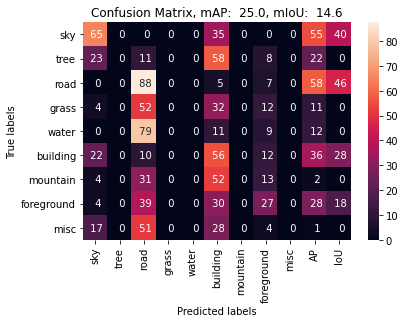

In [13]:
########################################################################
# TODO: Evaluate your result, and report Mean average precision on test dataset 
# using provided helper function. Here we show how we can train and evaluate the 
# simple model that we provided on the validation set. You will want to report
# performance on the validation set for the variants you tried, and the 
# performance of the final model on the test set.
model = simple_train()
gts, preds, classes = simple_predict('val', model)
aps, ious = segmentation_eval(gts, preds, classes, 'cs543-simple-val.pdf')